In [33]:
import os
import numpy as np
import sys
sys.path.append('../../scripts/')

import matplotlib.pyplot as plt
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', colors='banskt')

In [65]:
whichmethods = ['rr', 'matrixeqtl']
whichplot = 'fpr_tpr'
xlabel = 'FPR'
ylabel = 'TPR'

In [66]:
simdir = '15158_450_20_800_30_50_100_0.01_0.0_0.0_1.0_0.6_4.0_0.1_10_0.02'
srcdir = '/scratch/sbanerj/trans-eqtl/simulation'

In [67]:
def zoomplot(ax, xx, yy, label, zoom = 1, yerr = None):
    nx = len(xx)
    nplot = int(nx * zoom)
    ax.plot(xx[:nplot], yy[:nplot], label = label)

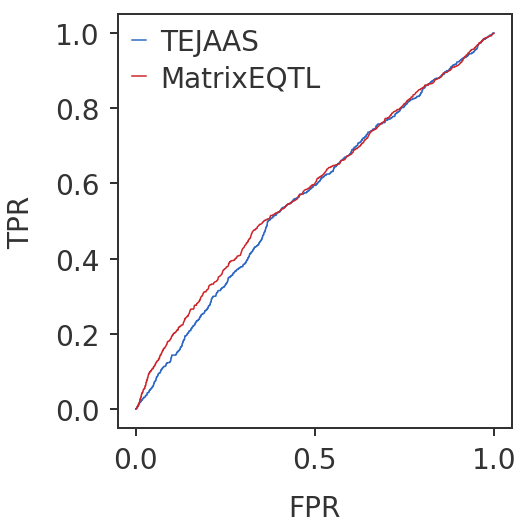

In [70]:
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)

label = {'jpa': 'CPMA', 
         'rr': 'TEJAAS', 
         'matrixeqtl': 'MatrixEQTL',
         'rand_jpa': 'CPMA (shuffled)',
         'rand_meqtl': 'MatrixEQTL (shuffled)',
         'rand_rr': 'TEJAAS (shuffled)'}

for key in whichmethods:
    outfile = os.path.join(srcdir, simdir, 'rocdata/{:s}_{:s}.txt'.format(key, whichplot))
    roc = np.loadtxt(outfile, skiprows=1)
    zoomplot(ax1, roc[:, 0], roc[:, 1], label[key], zoom = 1, yerr = roc[:, 2])

#ax1.legend()
#ax1.set_xlim([0, 200])
ax1.legend()
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)
#ax1.set_xlim([0, 1])
plt.tight_layout()
#plt.savefig(outfile, bbox_inches='tight')
plt.show()